<a href="https://www.kaggle.com/code/ardaorcun/sound-recognition?scriptVersionId=126771315" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import librosa 
import pandas as pd 
import numpy as np
import os 
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

In [2]:
Ravdess='/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'


In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
actor_list = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        actor_id = dir.split('_')[-1] 
        actor_list.append(actor_id)
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
actor_df = pd.DataFrame(actor_list, columns=['Actor'])
Ravdess_df = pd.concat([emotion_df, path_df, actor_df], axis=1)

Ravdess_df.Emotions.replace({1:'Doğal', 2:'Sakin', 3:'Mutlu', 4:'Üzgün', 5:'Kızgın', 6:'Korkmuş', 7:'İğrenmiş', 8:'Şaşırmış'}, inplace=True)
Ravdess_df.head()


,Emotions,Path,Actor
0,Şaşırmış,/kaggle/input/ravdess-emotional-speech-audio/a...,02
1,Doğal,/kaggle/input/ravdess-emotional-speech-audio/a...,02
2,İğrenmiş,/kaggle/input/ravdess-emotional-speech-audio/a...,02
3,İğrenmiş,/kaggle/input/ravdess-emotional-speech-audio/a...,02
4,Doğal,/kaggle/input/ravdess-emotional-speech-audio/a...,02


In [4]:
Ravdess_df['Actor'].value_counts()

02    60
17    60
18    60
13    60
03    60
14    60
09    60
10    60
19    60
04    60
22    60
24    60
23    60
12    60
06    60
15    60
08    60
20    60
11    60
01    60
21    60
16    60
05    60
07    60
Name: Actor, dtype: int64

First 20 values of y:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of y: (86082,)
Sample rate: 22050
The file duration is 3.9039455782312924 seconds


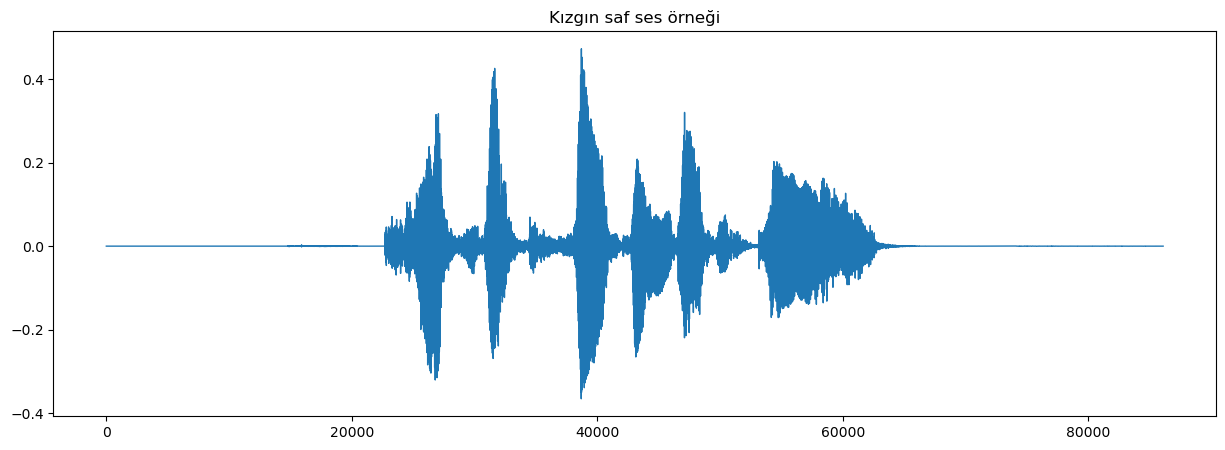

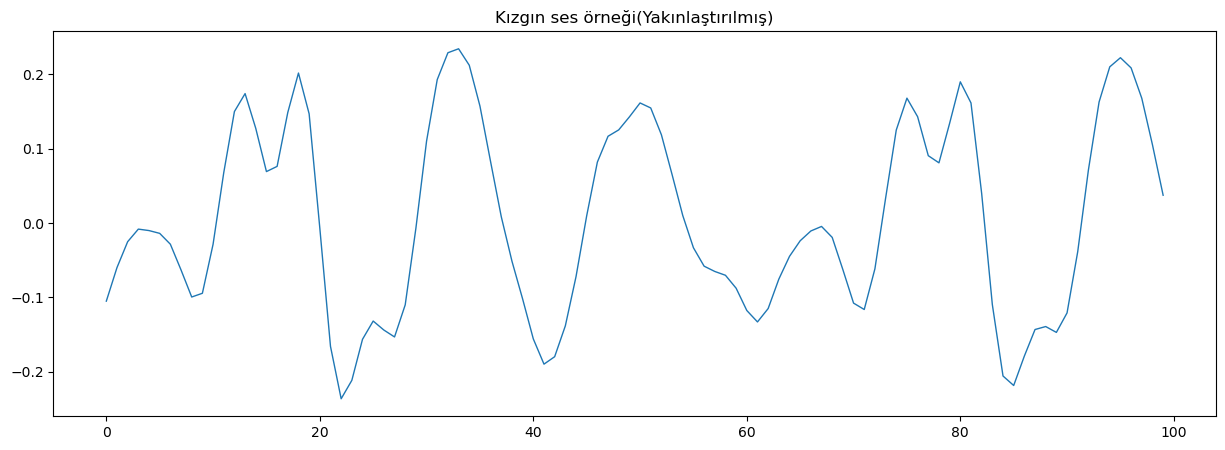

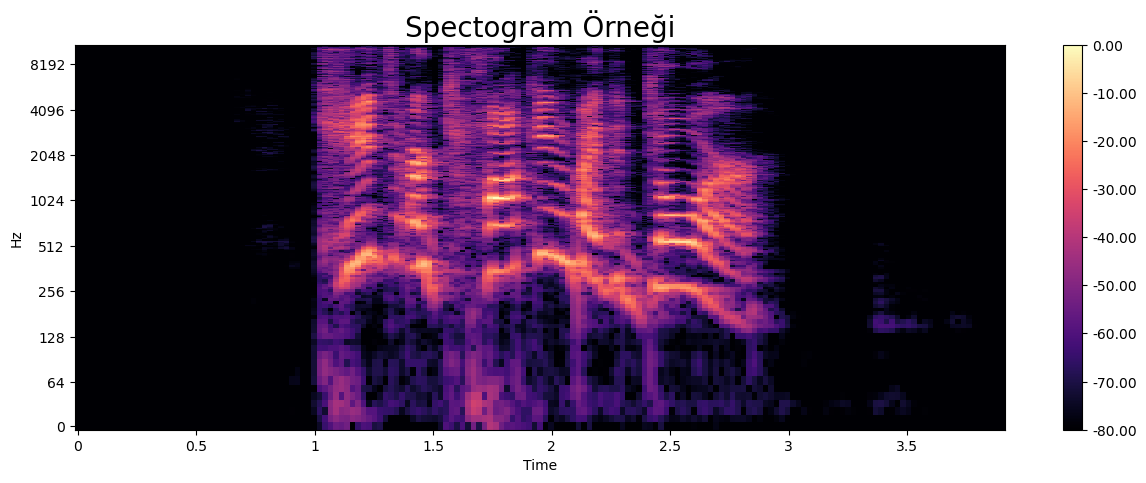

In [5]:
emotion='Kızgın'
path=np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]

y, sr= librosa.load(path)
print(f'First 20 values of y:{y[:20]}') #Means almost first 20 ms
print(f'Shape of y: {y.shape}')
print(f'Sample rate: {sr}')
duration=librosa.get_duration(y=y,sr=sr)
print(f'The file duration is {duration} seconds')
pd.Series(y).plot(figsize=(15,5),lw=1,title='Kızgın saf ses örneği')
plt.show()
pd.Series(y[40000:40100]).plot(figsize=(15,5), lw=1, title='Kızgın ses örneği(Yakınlaştırılmış)')
plt.show()
#Spectogram and a mathematical parts.
d=librosa.stft(y) #Fourier transform here
S_db=librosa.amplitude_to_db(np.abs(d), ref=np.max) #Changing ampitude to decibel.
a,ax=plt.subplots(figsize=(15,5))
img=librosa.display.specshow(S_db,
                            x_axis='time',
                            y_axis='log',#wave form after transformation.
                            ax=ax)
ax.set_title('Spectogram Örneği', fontsize=20)
a.colorbar(img, ax=ax,format=f'%0.2f')
plt.show()
ipd.Audio(path)
#Sondaki  grafikteki her bir farklılık bir öznitelik taşır. Bunu resimlerdei pixel gibi düşün

In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
def shift(data):
    shift_range=int(np.random.uniform(low=5,high=5)*1000)
    return np.roll(data, shift_range)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [7]:
def feature_extractors(data):
    result=np.array([])
    zcr=np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result,zcr))
    
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft))
    
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc))
    
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features (path):
    y, sr =librosa.load(path, duration=2.5, offset=0.6)
    res1=feature_extractors(y)
    result=np.array(res1)
    
    noise_data=noise(y)
    res2=feature_extractors(noise_data)
    result=np.vstack((result,res2))
    
    new_data=stretch(y)
    data_stretch_pitch=pitch(new_data, sr)
    res3=feature_extractors(data_stretch_pitch)
    result=np.vstack((result,res3))
    
    
    return result
    

In [8]:
X, Y = [],[]
for path, actor in tqdm(zip(Ravdess_df.Path,Ravdess_df.Actor)):
    feature=get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(actor)

1440it [10:06,  2.37it/s]


In [9]:
Features=pd.DataFrame(X)
Features['Labels']=Y
Features.to_csv('features.csv',index=False)
Features.tail()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,Labels
4315,0.274265,0.623635,0.680007,0.705876,0.766482,0.771273,0.685765,0.652298,0.649619,0.703012,...,0.002034,0.001952,0.002344,0.003193,0.003215,0.002738,0.002527,0.001292,0.000177,07
4316,0.209057,0.543219,0.543650,0.616389,0.620212,0.661719,0.627830,0.593303,0.601911,0.625616,...,0.000419,0.000513,0.000388,0.000415,0.000393,0.000604,0.000472,0.000435,0.000034,07
4317,0.148537,0.656566,0.652982,0.634403,0.652929,0.608521,0.557056,0.550457,0.628574,0.665743,...,0.014213,0.015852,0.012141,0.011468,0.008031,0.010061,0.015541,0.008099,0.000535,07
4318,0.239190,0.693910,0.701824,0.706617,0.722680,0.710706,0.622555,0.568655,0.643501,0.674804,...,0.016911,0.018782,0.015369,0.014770,0.011445,0.013298,0.018675,0.011119,0.003726,07
4319,0.173011,0.612217,0.651000,0.640020,0.634985,0.616633,0.588191,0.537216,0.543148,0.630741,...,0.003108,0.003310,0.003017,0.002794,0.002724,0.001945,0.001886,0.001045,0.000149,07


In [10]:
Features['Labels']=Features['Labels'].astype('object')

In [11]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 163 entries, 0 to Labels
dtypes: float64(162), object(1)
memory usage: 5.4+ MB


In [12]:
Features.to_csv('final_csv_actor.csv', index=False)

In [13]:
df=pd.read_csv('/kaggle/working/final_csv_actor.csv')

In [14]:
df['Labels'].astype('object')

0       2
1       2
2       2
3       2
4       2
       ..
4315    7
4316    7
4317    7
4318    7
4319    7
Name: Labels, Length: 4320, dtype: object

In [15]:
X=df.iloc[ : , : -1].values
Y=df['Labels'].values

In [16]:
encoder=OneHotEncoder()
Y=encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
x_train, x_test, y_train, y_test=train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, y_test.shape, x_test.shape

((3240, 162), (3240, 24), (1080, 24), (1080, 162))

In [18]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
x_train.shape, y_train.shape, x_test.shape,  y_test.shape

((3240, 162), (3240, 24), (1080, 162), (1080, 24))

In [19]:
num_labels=24

In [20]:
model=Sequential()

In [21]:
model.add(Dense(125, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               20375     
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [23]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [24]:
epoch=100
num_batch_size=32

In [25]:
model1=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=epoch, validation_data=(x_test,y_test), verbose=1)


Epoch 1/100
102/102 [==============================] - 2s 6ms/step - loss: 3.2539 - accuracy: 0.0753 - val_loss: 2.9056 - val_accuracy: 0.1806
Epoch 2/100
102/102 [==============================] - 0s 4ms/step - loss: 2.8754 - accuracy: 0.1435 - val_loss: 2.4616 - val_accuracy: 0.3167
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 2.5606 - accuracy: 0.2194 - val_loss: 2.0098 - val_accuracy: 0.5380
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 2.2253 - accuracy: 0.2935 - val_loss: 1.5896 - val_accuracy: 0.5926
Epoch 5/100
102/102 [==============================] - 0s 5ms/step - loss: 1.9472 - accuracy: 0.3855 - val_loss: 1.2926 - val_accuracy: 0.6935
Epoch 6/100
102/102 [==============================] - 0s 4ms/step - loss: 1.7201 - accuracy: 0.4417 - val_loss: 1.0692 - val_accuracy: 0.7556
Epoch 7/100
102/102 [==============================] - 0s 4ms/step - loss: 1.5639 - accuracy: 0.4938 - val_loss: 0.9262 - val_accuracy: 0.7676

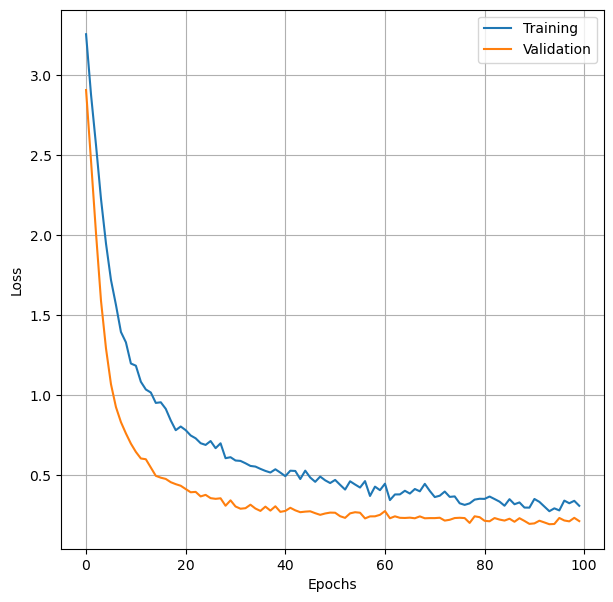

In [26]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()

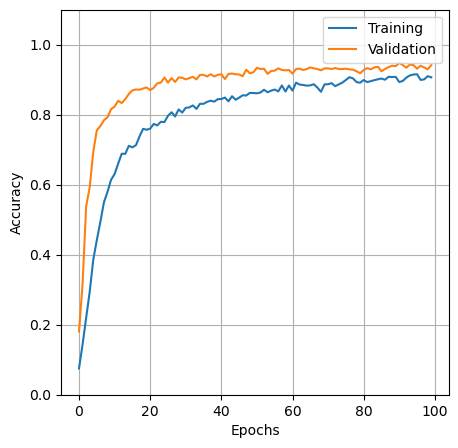

In [27]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [28]:
Y_pred_test=model.predict(x_test)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(y_test,axis=1),Y_pred_test)
print(classification)

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        45
           1       0.90      1.00      0.95        43
           2       0.96      0.94      0.95        52
           3       0.95      0.93      0.94        44
           4       0.89      0.92      0.91        53
           5       0.91      1.00      0.96        43
           6       0.98      0.96      0.97        45
           7       0.90      0.88      0.89        41
           8       0.96      0.92      0.94        48
           9       0.94      0.94      0.94        33
          10       0.87      1.00      0.93        40
          11       1.00      0.96      0.98        49
          12       0.97      0.97      0.97        39
          13       0.86      1.00      0.92        42
          14       1.00      0.98      0.99        48
          15       0.98      0.96      0.97        57
          16       1.00     

In [29]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 0s 2ms/step


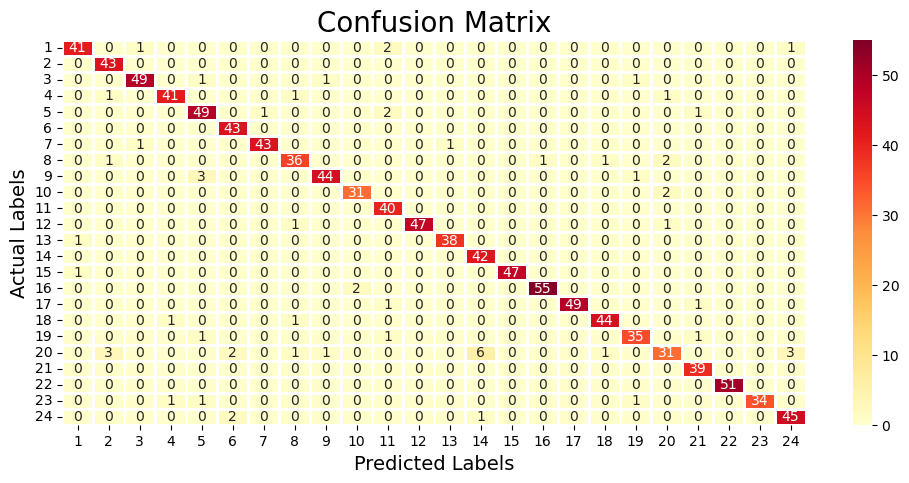

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='YlOrRd', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()